In [1]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

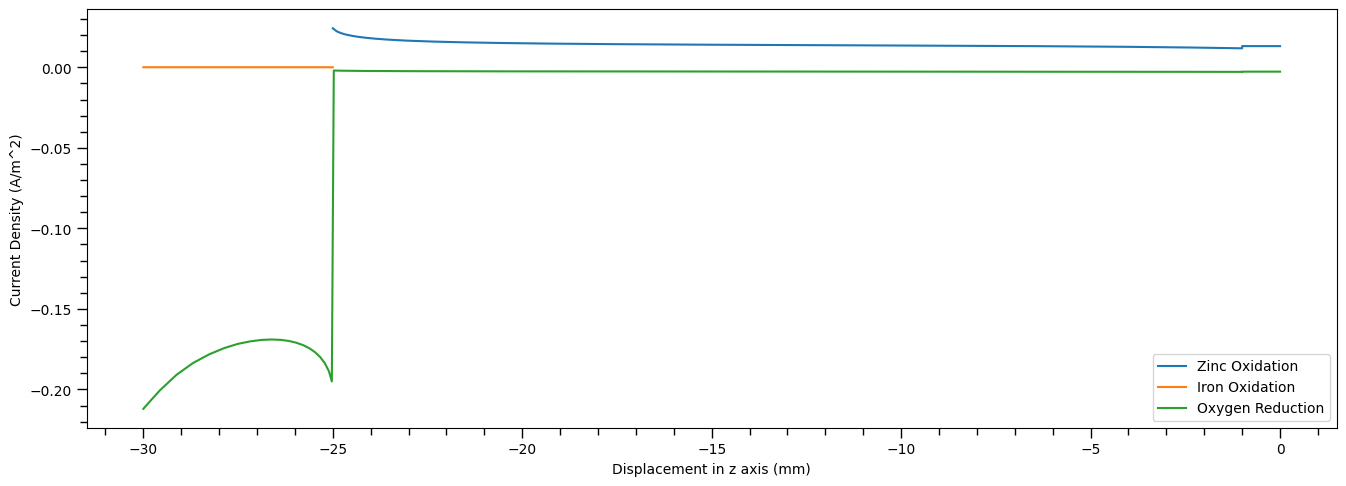

In [2]:
### IMPORTING DATA FROM COMSOL .txts

ZnOx_data = np.loadtxt('ZnOx.txt')
FeOx_data = np.loadtxt('FeOx.txt')
OxyRed_data = np.loadtxt('OxyRed.txt')

plt.plot(ZnOx_data[:,0], ZnOx_data[:,1], label='Zinc Oxidation')
plt.plot(FeOx_data[:,0], FeOx_data[:,1], label='Iron Oxidation')
plt.plot(OxyRed_data[:,0], OxyRed_data[:,1], label='Oxygen Reduction')
plt.legend()

plt.minorticks_on()
plt.tick_params(axis='both', direction='out', length=7, width=1)
plt.tick_params(axis='both', which='minor', direction='out', length=5, width=1)
plt.xlabel('Displacement in z axis (mm)')
plt.ylabel('Current Density (A/m^2)')
plt.tight_layout()
plt.gcf().set_size_inches(15, 5)

plt.show()

In [3]:
# File paths and labels
file_paths = [
    ("Ter_Current_Density(+oxygen).txt", "Tertiary Current Density"),
    ("FeOx.txt", "Iron Oxidation"),
    ("ZnOx.txt", "Zinc Oxidation"),
    ("OxyRed.txt", "Oxygen Reduction"),
    ("ZnOx_rvalues.txt", "ZnOx / r"),
    ("OxRed_rvalues.txt", "Oxygen Reduction / r")]

# Load data
data = [np.loadtxt(file_path) for file_path, _ in file_paths]

In [4]:
### SPLITTING X,Y DATA

TerJ_x_values = data[0][:, 0]
TerJ_y_values = data[0][:, 1]
FeOx_x_values = data[1][:, 0]
FeOx_y_values = data[1][:, 1]
ZnOx_x_values = data[2][:, 0]
ZnOx_y_values = data[2][:, 1]
ORed_x_values = data[3][:, 0]
ORed_y_values = data[3][:, 1]
ZnOx_rvalues_x_values = data[4][:, 0]
ZnOx_rvalues_y_values = data[4][:, 1]
ORed_rvalues_x_values = data[5][:, 0]
ORed_rvalues_y_values = data[5][:, 1]

In [5]:
def cylinder_TotI(S: float, T: float, z:np.ndarray, j:np.ndarray) -> float:
    """
    Calculate total current for a cylinder.

    Parameters:
    S (float) :    Surface area.
    T (float) :    Thickness.
    z (array_like) :    z values.
    j (array_like) :    Current density.

    Returns:
    (float):    Total current.
    """

    N = len(z) - 1
    Acylinder = 2 * np.pi * S * T
    w = np.zeros(N + 1)
    
    # Compute weights
    w[0] = 1 / (2 * T) * (z[1] - z[0])
    w[N] = 1 / (2 * T) * (z[N] - z[N - 1])
    for i in range(1, N):
        w[i] = 1 / (2 * T) * (z[i + 1] - z[i - 1])
    
    j_avg = np.sum(w * j) # Average current density
    Icylinder = Acylinder * j_avg # Total current
    
    return Icylinder

Ox_Icylinder = cylinder_TotI(1, 24, ZnOx_x_values, ZnOx_y_values)
mask = (ORed_x_values >= 1) & (ORed_x_values <= 24)

# Mask the ORed data
limited_x_values = ORed_x_values[mask]
limited_y_values = ORed_y_values[mask]

In [6]:
def cone_TotI(R, h, z, j):
    """
    Calculate the total current for the cone section using the given current densities.

    Parameters:
    R (float): Radius of the base of the cone.
    h (float): Slant height of the cone.
    z (array-like): Positions along the slant height where current density is measured.
    j (array-like): Current densities measured at corresponding z positions.

    Returns:
    float: The total current for the cone section
    """

    N = len(z) - 1  # Number of intervals
    A_cone = np.pi * R * np.sqrt(h**2 + R**2)
    w = np.zeros(N + 1)

    f = (z - z[0]) / h

    # Compute weights
    w[0] = 0  # Weight for the first point
    w[N] = 1 - f[N-1]  # Weight for the last point
    for i in range(1, N):
        w[i] = f[i] * (f[i+1] - f[i-1])

    # Compute average current density
    j_avg = np.sum(w * j)

    # Compute total current
    I_cone = A_cone * j_avg
    
    return I_cone

# Example usage
R = 1  # radius of the base of the cone
h = 5  # slant height of the cone
z = FeOx_x_values  # positions
j = FeOx_y_values  # current densities at positions

I_cone = cone_TotI(R, h, z, j)

In [7]:
def UHead_TotI(R, W, r, j):
    """
    Calculate the total current for the head under the nail using the given current densities.

    Parameters:
    R (float): Radius of the head of the nail.
    W (float): Radius of the head of the nail.
    r (array-like): Positions along the radius where current density is measured.
    j (array-like): Current densities measured at corresponding r positions.

    Returns:
    float: The total current for the head under the nail
    """
    N = len(r) - 1  # Number of intervals
    A_head_under = np.pi * (W**2 - R**2)
    w = np.zeros(N + 1)

    # Calculate a and b
    a = R / (W + R)
    b = (W - R) / (W + R)
    g = (r - R) / (W - R)

    # Compute weights
    w[0] = (a + b * g[0]) * (g[1] - g[0])  # For the first point
    w[N] = (a + b * g[N]) * (g[N] - g[N-1])  # For the last point
    for i in range(1, N):
        w[i] = (a + b * g[i]) * (g[i+1] - g[i-1])

    # Compute average current density
    j_avg = np.sum(w * j)

    # Compute total current
    I_head_under = A_head_under * j_avg
    
    return I_head_under

In [8]:
def compute_total_current_cylinder(ZnOx_x_values, ZnOx_y_values, ORed_x_values, ORed_y_values):
    mask_ZnOx = (ZnOx_x_values >= -25) & (ZnOx_x_values <= -1)
    mask_ORed = (ORed_x_values >= -25) & (ORed_x_values <= -1)

    filtered_ZnOx_x_values = ZnOx_x_values[mask_ZnOx]
    filtered_ZnOx_y_values = ZnOx_y_values[mask_ZnOx]

    filtered_ORed_x_values = ORed_x_values[mask_ORed]
    filtered_ORed_y_values = ORed_y_values[mask_ORed]

    total_current_cylinder_ZnOx = cylinder_TotI(1, 24, filtered_ZnOx_x_values, filtered_ZnOx_y_values)
    total_current_cylinder_ORed = cylinder_TotI(1, 24, filtered_ORed_x_values, filtered_ORed_y_values)

    total_current_cylinder = total_current_cylinder_ZnOx + total_current_cylinder_ORed
    return total_current_cylinder

def compute_total_current_cone(ORed_x_values, ORed_y_values, FeOx_x_values, FeOx_y_values):
    mask_cone = (ORed_x_values >= -30) & (ORed_x_values <= -25)
    filtered_cone_x_values = ORed_x_values[mask_cone]
    filtered_cone_y_values = ORed_y_values[mask_cone]

    current_cone_ORed = cone_TotI(1, 5, filtered_cone_x_values, filtered_cone_y_values)
    current_cone_FeOx = cone_TotI(1, 5, FeOx_x_values, FeOx_y_values)
    total_current_cone = current_cone_ORed + current_cone_FeOx
    return total_current_cone

def compute_total_current_head(ZnOx_x_values, ZnOx_y_values, ORed_x_values, ORed_y_values, ZnOx_rvalues_x_values, ZnOx_rvalues_y_values, ORed_rvalues_x_values, ORed_rvalues_y_values):
    mask_or_x = (ORed_x_values >= -1) & (ORed_x_values <= 0)
    mask_zn_x = (ZnOx_x_values >= -1) & (ZnOx_x_values <= 0)
    mask_or_r = (ORed_rvalues_x_values >= 1) & (ORed_rvalues_x_values <= 5)
    mask_zn_r = (ZnOx_rvalues_x_values >= 1) & (ZnOx_rvalues_x_values <= 5)

    filtered_or_x_values = ORed_x_values[mask_or_x]
    filtered_or_y_values = ORed_y_values[mask_or_x]

    filtered_zn_x_values = ZnOx_x_values[mask_zn_x]
    filtered_zn_y_values = ZnOx_y_values[mask_zn_x]

    filtered_or_rvalues_x_values = ORed_rvalues_x_values[mask_or_r]
    filtered_or_rvalues_y_values = ORed_rvalues_y_values[mask_or_r]

    filtered_zn_rvalues_x_values = ZnOx_rvalues_x_values[mask_zn_r]
    filtered_zn_rvalues_y_values = ZnOx_rvalues_y_values[mask_zn_r]

    total_current_cylinder_or = cylinder_TotI(5, 1, filtered_or_x_values, filtered_or_y_values)
    total_current_cylinder_zn = cylinder_TotI(5, 1, filtered_zn_x_values, filtered_zn_y_values)
    total_current_head_or = UHead_TotI(1, 5, filtered_or_rvalues_x_values, filtered_or_rvalues_y_values)
    total_current_head_zn = UHead_TotI(1, 5, filtered_zn_rvalues_x_values, filtered_zn_rvalues_y_values)

    total_current_head = total_current_cylinder_or + total_current_cylinder_zn + total_current_head_or + total_current_head_zn
    return total_current_head


In [9]:
CylinderCurrent = compute_total_current_cylinder(ZnOx_x_values, ZnOx_y_values, ORed_x_values, ORed_y_values)
HeadCurrent = compute_total_current_head(ZnOx_x_values, ZnOx_y_values, ORed_x_values, ORed_y_values, ZnOx_rvalues_x_values, ZnOx_rvalues_y_values, ORed_rvalues_x_values, ORed_rvalues_y_values)
ConeCurrent = compute_total_current_cone(ORed_x_values, ORed_y_values, FeOx_x_values, FeOx_y_values)

data = {
    "Component": ["Cylinder", "Head", "Cone"],
    "Total Current (A)": [round(HeadCurrent, 5), round(CylinderCurrent, 5), round(ConeCurrent, 5)]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Print the table
display(df)


,Component,Total Current (A)
0,Cylinder,1.07092
1,Head,1.73987
2,Cone,-2.80663
